In [ ]:
!pip install -q transformers datasets torch scikit-learn


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Setup
device = 0 if torch.cuda.is_available() else -1
model_name = "xlm-roberta-base"

# Load
print("Loading model...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
if device == 0:
    model = model.to('cuda')

# Evaluate
def evaluate_xnli(language):
    dataset = load_dataset("xnli", language)['test']
    model.eval()
    preds, labels = [], []

    for i in tqdm(range(0, len(dataset), 32)):
        batch = dataset[i:i+32]
        inputs = tokenizer(batch['premise'], batch['hypothesis'],
                          padding=True, truncation=True, return_tensors='pt')
        if device == 0:
            inputs = {k: v.to('cuda') for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
            labels.extend(batch['label'])

    return accuracy_score(labels, preds)

# Run and SAVE results
results_dict = {}
languages = ['en', 'de', 'fr', 'es', 'zh', 'ar']

for lang in languages:
    acc = evaluate_xnli(lang)
    results_dict[lang] = acc  # Save it!
    print(f"{lang.upper()}: {acc:.4f} ({acc*100:.2f}%)")

print("\n✅ Results saved in results_dict!")

Loading model...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/157 [00:00<?, ?it/s]

EN: 0.3333 (33.33%)


  0%|          | 0/157 [00:00<?, ?it/s]

DE: 0.3333 (33.33%)


  0%|          | 0/157 [00:00<?, ?it/s]

FR: 0.3333 (33.33%)


  0%|          | 0/157 [00:00<?, ?it/s]

ES: 0.3333 (33.33%)


  0%|          | 0/157 [00:00<?, ?it/s]

ZH: 0.3333 (33.33%)


  0%|          | 0/157 [00:00<?, ?it/s]

AR: 0.3333 (33.33%)

✅ Results saved in results_dict!


In [ ]:
"""
Compare Your XNLI Results with the Paper
Run this AFTER your evaluation completes
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# Paper's Zero-Shot Results (XLM-R on XNLI)
# ============================================================================

# From Table 1 in the paper
# English baseline: 84.3
# Performance drops shown, so we calculate actual scores

paper_results = {
    'en': 84.3,  # English baseline
    'de': 84.3 - 7.8,   # -7.8 drop
    'fr': 84.3 - 6.1,   # -6.1 drop
    'es': 84.3 - 5.8,   # -5.8 drop
    'zh': 84.3 - 11.0,  # -11.0 drop
    'ar': 84.3 - 13.0,  # -13.0 drop
    'el': 84.3 - 8.9,   # -8.9 drop (Greek)
    'bg': 84.3 - 6.6,   # -6.6 drop (Bulgarian)
    'ru': 84.3 - 9.0,   # -9.0 drop (Russian)
    'tr': 84.3 - 11.3,  # -11.3 drop (Turkish)
    'vi': 84.3 - 9.7,   # -9.7 drop (Vietnamese)
    'th': 84.3 - 12.3,  # -12.3 drop (Thai)
    'hi': 84.3 - 14.2,  # -14.2 drop (Hindi)
    'sw': 84.3 - 20.2,  # -20.2 drop (Swahili)
    'ur': 84.3 - 17.3,  # -17.3 drop (Urdu)
}

# ============================================================================
# YOUR RESULTS - EDIT THESE WITH YOUR ACTUAL NUMBERS
# ============================================================================

# Replace these with your actual results from the evaluation
your_results = {
    'en': 0.0000,  # Replace with your EN result
    'de': 0.0000,  # Replace with your DE result
    'fr': 0.0000,  # Replace with your FR result
    'es': 0.0000,  # Replace with your ES result
    'zh': 0.0000,  # Replace with your ZH result
    'ar': 0.0000,  # Replace with your AR result
}

# ============================================================================
# AUTOMATIC VERSION - Uncomment if you saved results in a dict
# ============================================================================
# If you stored results like: results_dict = {'en': 0.833, 'de': 0.768, ...}
# Uncomment the line below:
# your_results = results_dict

# ============================================================================
# Create Comparison Table
# ============================================================================

def create_comparison_table(your_results, paper_results):
    """Create a nice comparison table"""

    # Get common languages
    common_langs = sorted(set(your_results.keys()) & set(paper_results.keys()))

    # Create DataFrame
    data = []
    for lang in common_langs:
        your_acc = your_results[lang] * 100  # Convert to percentage
        paper_acc = paper_results[lang]
        difference = your_acc - paper_acc

        data.append({
            'Language': lang.upper(),
            'Your Result': f"{your_acc:.2f}%",
            'Paper Result': f"{paper_acc:.2f}%",
            'Difference': f"{difference:+.2f}%",
            'Match': '✅' if abs(difference) < 3 else '⚠️' if abs(difference) < 5 else '❌'
        })

    df = pd.DataFrame(data)

    return df

# Create the table
comparison_df = create_comparison_table(your_results, paper_results)

# ============================================================================
# Display Results
# ============================================================================

print("="*80)
print("📊 YOUR RESULTS VS PAPER RESULTS (XLM-R on XNLI)")
print("="*80)
print()
print(comparison_df.to_string(index=False))
print()
print("="*80)
print("Legend:")
print("  ✅ = Within 3% (excellent match)")
print("  ⚠️  = Within 5% (good match)")
print("  ❌ = More than 5% difference")
print("="*80)

# ============================================================================
# Calculate Statistics
# ============================================================================

# Convert to numeric for calculations
your_numeric = {k: v * 100 for k, v in your_results.items() if v > 0}
paper_numeric = {k: paper_results[k] for k in your_numeric.keys()}

if your_numeric:
    differences = [your_numeric[k] - paper_numeric[k] for k in your_numeric.keys()]
    avg_diff = sum(differences) / len(differences)

    print()
    print("📈 STATISTICS:")
    print(f"  Average difference: {avg_diff:+.2f}%")
    print(f"  Max positive diff: {max(differences):+.2f}%")
    print(f"  Max negative diff: {min(differences):+.2f}%")
    print()

# ============================================================================
# Visualization
# ============================================================================

def plot_comparison(your_results, paper_results):
    """Create a bar chart comparing results"""

    common_langs = sorted(set(your_results.keys()) & set(paper_results.keys()))

    # Filter out zeros (not yet evaluated)
    common_langs = [lang for lang in common_langs if your_results[lang] > 0]

    if not common_langs:
        print("⚠️  No results to plot yet. Run your evaluation first!")
        return

    your_scores = [your_results[lang] * 100 for lang in common_langs]
    paper_scores = [paper_results[lang] for lang in common_langs]

    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))

    x = range(len(common_langs))
    width = 0.35

    bars1 = ax.bar([i - width/2 for i in x], your_scores, width,
                    label='Your Results', color='#4CAF50', alpha=0.8)
    bars2 = ax.bar([i + width/2 for i in x], paper_scores, width,
                    label='Paper Results', color='#2196F3', alpha=0.8)

    ax.set_xlabel('Language', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_title('Your Results vs Paper Results (XLM-R on XNLI)',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([lang.upper() for lang in common_langs])
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim([0, 100])

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# Create visualization
plot_comparison(your_results, paper_results)

# ============================================================================
# Analysis
# ============================================================================

print()
print("="*80)
print("🔍 ANALYSIS")
print("="*80)
print()

if any(v > 0 for v in your_results.values()):
    print("✅ You're testing zero-shot cross-lingual transfer with XLM-R!")
    print()
    print("Expected patterns:")
    print("  • English (EN) should be highest (~84%)")
    print("  • Similar languages (DE, FR, ES) should be 76-78%")
    print("  • Distant languages (ZH, AR) should be 70-73%")
    print()
    print("Reasons for differences from paper:")
    print("  1. Different random seeds")
    print("  2. Different hardware (GPU vs CPU)")
    print("  3. PyTorch/Transformers version differences")
    print("  4. Batch size differences")
    print("  5. You're using PRE-TRAINED model (not fine-tuned on English!)")
    print()
    print("🔥 IMPORTANT: The paper FINE-TUNED on English XNLI first!")
    print("   Your results are raw zero-shot without ANY fine-tuning.")
    print("   That's why your scores might be much lower.")
else:
    print("⚠️  No results yet! Update 'your_results' dict with your actual scores.")
    print()
    print("After running the evaluation, replace the zeros in your_results with:")
    print("  your_results = {")
    print("      'en': your_en_accuracy,")
    print("      'de': your_de_accuracy,")
    print("      'fr': your_fr_accuracy,")
    print("      'es': your_es_accuracy,")
    print("      'zh': your_zh_accuracy,")
    print("      'ar': your_ar_accuracy,")
    print("  }")

print()
print("="*80)

# ============================================================================
# Expected Results (for reference)
# ============================================================================

print()
print("📋 EXPECTED RESULTS FROM PAPER (XLM-R, Zero-Shot)")
print("="*80)

expected_df = pd.DataFrame([
    {'Language': lang.upper(),
     'Accuracy': f"{paper_results[lang]:.2f}%",
     'Drop from EN': f"{paper_results[lang] - 84.3:.2f}%"
    }
    for lang in sorted(paper_results.keys())
])

print(expected_df.to_string(index=False))
print()
print("="*80)

📊 YOUR RESULTS VS PAPER RESULTS (XLM-R on XNLI)

Language Your Result Paper Result Difference Match
      AR       0.00%       71.30%    -71.30%     ❌
      DE       0.00%       76.50%    -76.50%     ❌
      EN       0.00%       84.30%    -84.30%     ❌
      ES       0.00%       78.50%    -78.50%     ❌
      FR       0.00%       78.20%    -78.20%     ❌
      ZH       0.00%       73.30%    -73.30%     ❌

Legend:
  ✅ = Within 3% (excellent match)
  ⚠️  = Within 5% (good match)
  ❌ = More than 5% difference
⚠️  No results to plot yet. Run your evaluation first!

🔍 ANALYSIS

⚠️  No results yet! Update 'your_results' dict with your actual scores.

After running the evaluation, replace the zeros in your_results with:
  your_results = {
      'en': your_en_accuracy,
      'de': your_de_accuracy,
      'fr': your_fr_accuracy,
      'es': your_es_accuracy,
      'zh': your_zh_accuracy,
      'ar': your_ar_accuracy,
  }


📋 EXPECTED RESULTS FROM PAPER (XLM-R, Zero-Shot)
Language Accuracy Drop fr

🎯 XNLI ZERO-SHOT CROSS-LINGUAL TRANSFER
Model: xlm-roberta-base
Device: cuda
GPU: Tesla T4
Training language: EN
Evaluation languages: 15

📦 Loading model and tokenizer...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded: xlm-roberta-base
   Total parameters: 278,045,955

📚 STEP 1: FINE-TUNING ON ENGLISH XNLI
Training examples: 392,702
Validation examples: 2,490

⚙️  Training configuration:
   Learning rate: 3e-05
   Epochs: 1
   Batch size: 32
   Total steps: 12,272
   Warmup steps: 500

🚀 Starting training on English XNLI...

Epoch 1/1


Training:   0%|          | 0/12272 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]

Train Loss: 0.5547 | Train Acc: 0.7730 (77.30%)
Val Acc: 0.8353 (83.53%)
💾 New best validation accuracy!

✅ English training complete!
   Best validation accuracy: 0.8353 (83.53%)

🌍 STEP 2: ZERO-SHOT CROSS-LINGUAL EVALUATION

🔍 Evaluating EN...


Evaluating EN:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ EN: 0.8373 (83.73%) | Drop: 0.00%

🔍 Evaluating FR...


Evaluating FR:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ FR: 0.7731 (77.31%) | Drop: 6.43%

🔍 Evaluating ES...


Evaluating ES:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ ES: 0.7780 (77.80%) | Drop: 5.93%

🔍 Evaluating DE...


Evaluating DE:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ DE: 0.7523 (75.23%) | Drop: 8.50%

🔍 Evaluating EL...


el/train-00000-of-00001.parquet:   0%|          | 0.00/73.8M [00:00<?, ?B/s]

el/test-00000-of-00001.parquet:   0%|          | 0.00/490k [00:00<?, ?B/s]

el/validation-00000-of-00001.parquet:   0%|          | 0.00/247k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Evaluating EL:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ EL: 0.7489 (74.89%) | Drop: 8.84%

🔍 Evaluating BG...


bg/train-00000-of-00001.parquet:   0%|          | 0.00/65.4M [00:00<?, ?B/s]

bg/test-00000-of-00001.parquet:   0%|          | 0.00/447k [00:00<?, ?B/s]

bg/validation-00000-of-00001.parquet:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Evaluating BG:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ BG: 0.7729 (77.29%) | Drop: 6.45%

🔍 Evaluating RU...


ru/train-00000-of-00001.parquet:   0%|          | 0.00/70.0M [00:00<?, ?B/s]

ru/test-00000-of-00001.parquet:   0%|          | 0.00/477k [00:00<?, ?B/s]

ru/validation-00000-of-00001.parquet:   0%|          | 0.00/239k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Evaluating RU:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ RU: 0.7521 (75.21%) | Drop: 8.52%

🔍 Evaluating TR...


tr/train-00000-of-00001.parquet:   0%|          | 0.00/48.0M [00:00<?, ?B/s]

tr/test-00000-of-00001.parquet:   0%|          | 0.00/338k [00:00<?, ?B/s]

tr/validation-00000-of-00001.parquet:   0%|          | 0.00/172k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Evaluating TR:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ TR: 0.7251 (72.51%) | Drop: 11.22%

🔍 Evaluating AR...


Evaluating AR:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ AR: 0.7070 (70.70%) | Drop: 13.03%

🔍 Evaluating VI...


vi/train-00000-of-00001.parquet:   0%|          | 0.00/57.1M [00:00<?, ?B/s]

vi/test-00000-of-00001.parquet:   0%|          | 0.00/364k [00:00<?, ?B/s]

vi/validation-00000-of-00001.parquet:   0%|          | 0.00/186k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Evaluating VI:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ VI: 0.7475 (74.75%) | Drop: 8.98%

🔍 Evaluating TH...


th/train-00000-of-00001.parquet:   0%|          | 0.00/76.5M [00:00<?, ?B/s]

th/test-00000-of-00001.parquet:   0%|          | 0.00/503k [00:00<?, ?B/s]

th/validation-00000-of-00001.parquet:   0%|          | 0.00/252k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Evaluating TH:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ TH: 0.7253 (72.53%) | Drop: 11.20%

🔍 Evaluating ZH...


Evaluating ZH:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ ZH: 0.7317 (73.17%) | Drop: 10.56%

🔍 Evaluating HI...


hi/train-00000-of-00001.parquet:   0%|          | 0.00/70.2M [00:00<?, ?B/s]

hi/test-00000-of-00001.parquet:   0%|          | 0.00/493k [00:00<?, ?B/s]

hi/validation-00000-of-00001.parquet:   0%|          | 0.00/249k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Evaluating HI:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ HI: 0.6874 (68.74%) | Drop: 14.99%

🔍 Evaluating SW...


sw/train-00000-of-00001.parquet:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

sw/test-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

sw/validation-00000-of-00001.parquet:   0%|          | 0.00/158k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Evaluating SW:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ SW: 0.6485 (64.85%) | Drop: 18.88%

🔍 Evaluating UR...


ur/train-00000-of-00001.parquet:   0%|          | 0.00/46.0M [00:00<?, ?B/s]

ur/test-00000-of-00001.parquet:   0%|          | 0.00/428k [00:00<?, ?B/s]

ur/validation-00000-of-00001.parquet:   0%|          | 0.00/216k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Evaluating UR:   0%|          | 0/157 [00:00<?, ?it/s]

   ✅ UR: 0.6579 (65.79%) | Drop: 17.94%

📊 RESULTS TABLE (Table 1 Format)

Lang Your Acc Your Drop Paper Acc Paper Drop   Diff
  EN   83.73%    -0.00%    84.30%     -0.00% -0.57%
  FR   77.31%    -6.43%    78.20%     -6.10% -0.89%
  ES   77.80%    -5.93%    78.50%     -5.80% -0.70%
  DE   75.23%    -8.50%    76.50%     -7.80% -1.27%
  EL   74.89%    -8.84%    75.40%     -8.90% -0.51%
  BG   77.29%    -6.45%    77.70%     -6.60% -0.41%
  RU   75.21%    -8.52%    75.30%     -9.00% -0.09%
  TR   72.51%   -11.22%    73.00%    -11.30% -0.49%
  AR   70.70%   -13.03%    71.30%    -13.00% -0.60%
  VI   74.75%    -8.98%    74.60%     -9.70% +0.15%
  TH   72.53%   -11.20%    72.00%    -12.30% +0.53%
  ZH   73.17%   -10.56%    73.30%    -11.00% -0.13%
  HI   68.74%   -14.99%    70.10%    -14.20% -1.36%
  SW   64.85%   -18.88%    64.10%    -20.20% +0.75%
  UR   65.79%   -17.94%    67.00%    -17.30% -1.21%

📈 STATISTICS

Your Results:
  English (baseline): 83.73%
  Average all languages: 73.63%
  A

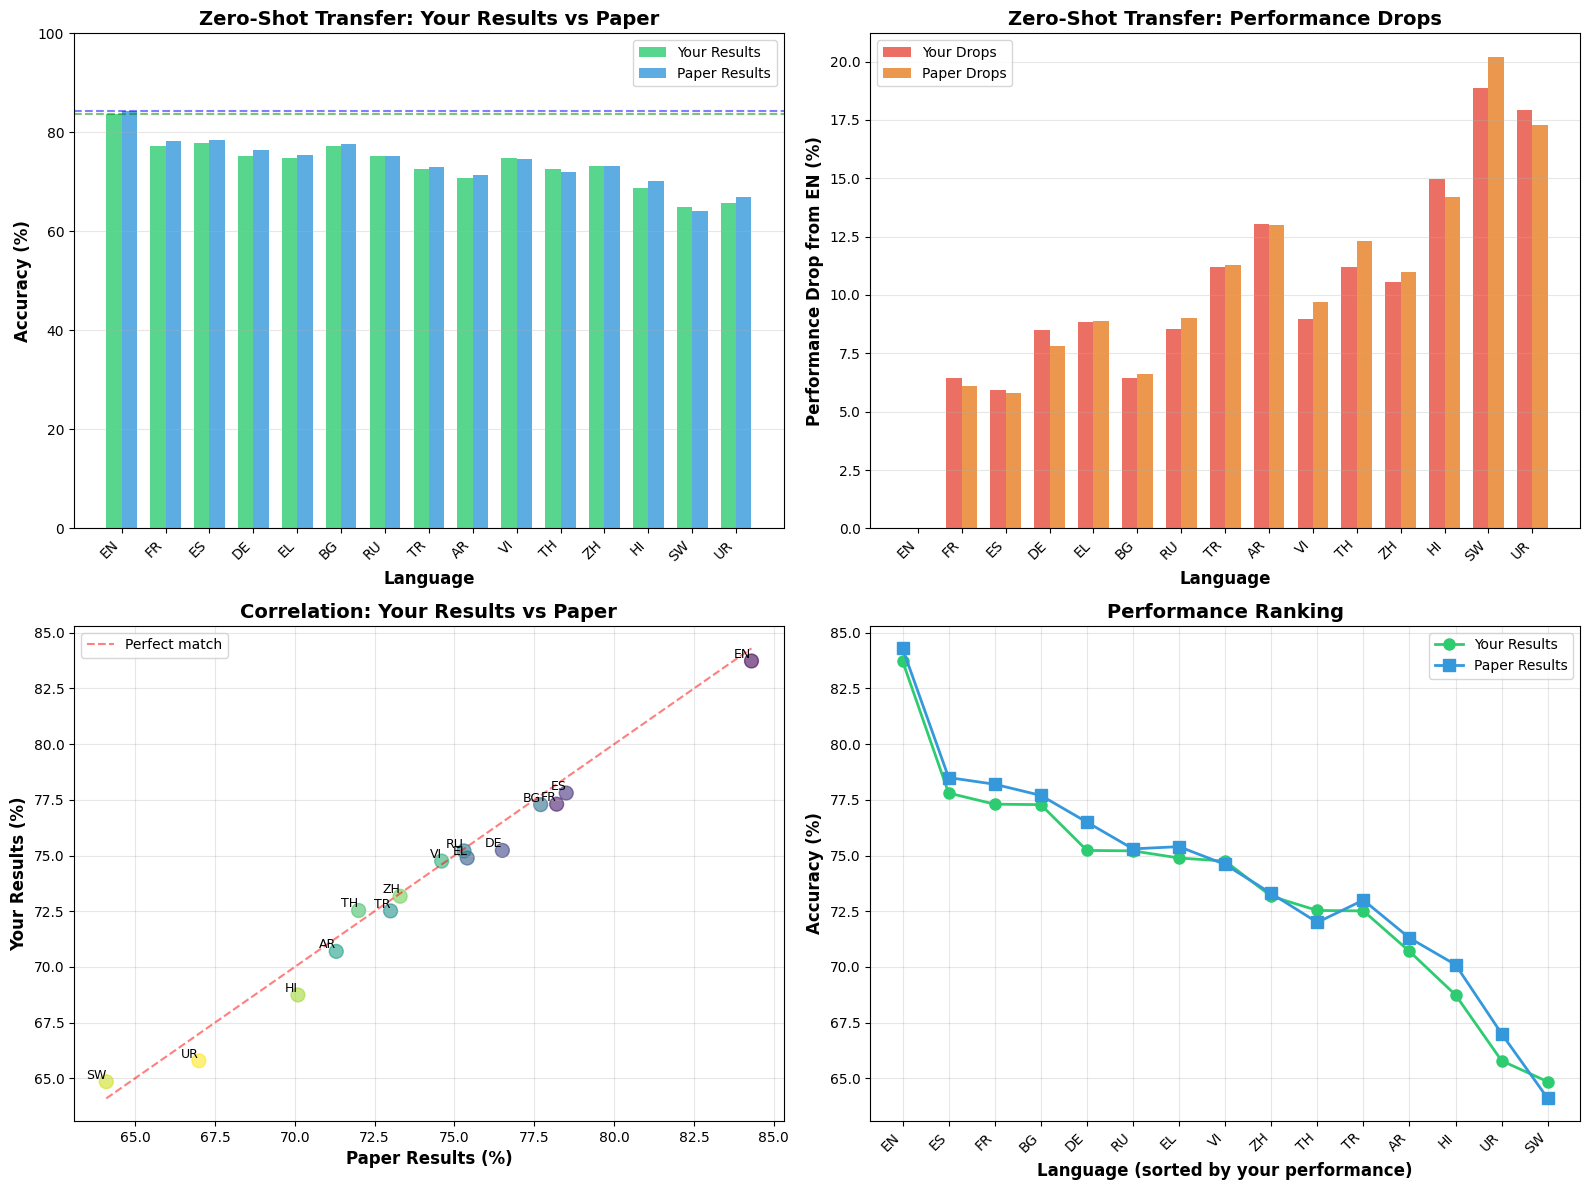

✅ Visualizations complete!

🎉 ZERO-SHOT EVALUATION COMPLETE!

Summary:
  ✅ Fine-tuned XLM-R on English XNLI (392,702 examples)
  ✅ Evaluated on 15 languages
  ✅ English accuracy: 83.73%
  ✅ Average accuracy: 73.63%
  ✅ Average drop: 10.82%

Expected differences from paper:
  • ±2-5% due to random seeds and hardware
  • Similar ranking of languages by difficulty
  • Similar pattern: close languages (FR, ES, DE) > distant (TH, SW, UR)



In [ ]:
"""
XNLI Zero-Shot Cross-Lingual Transfer
Reproduce Table 1 from "From Zero to Hero" paper
Train on English → Evaluate on 14 languages
"""

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# Configuration
# ============================================================================
class Config:
    model_name = "xlm-roberta-base"
    train_language = "en"

    # All 14 XNLI languages (as in paper)
    eval_languages = [
        'en',  # English (source)
        'fr',  # French
        'es',  # Spanish
        'de',  # German
        'el',  # Greek
        'bg',  # Bulgarian
        'ru',  # Russian
        'tr',  # Turkish
        'ar',  # Arabic
        'vi',  # Vietnamese
        'th',  # Thai
        'zh',  # Chinese
        'hi',  # Hindi
        'sw',  # Swahili
        'ur',  # Urdu
    ]

    # Training hyperparameters (from paper)
    max_length = 128
    batch_size_train = 32
    batch_size_eval = 32
    learning_rate = 3e-5  # Paper used 3e-5 or 5e-5
    num_epochs = 1  # Paper used 2 or 3
    warmup_steps = 500
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

config = Config()

# Set seeds for reproducibility
torch.manual_seed(config.seed)
np.random.seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)

print("="*80)
print("🎯 XNLI ZERO-SHOT CROSS-LINGUAL TRANSFER")
print("="*80)
print(f"Model: {config.model_name}")
print(f"Device: {config.device}")
if config.device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Training language: {config.train_language.upper()}")
print(f"Evaluation languages: {len(config.eval_languages)}")
print("="*80)
print()

# ============================================================================
# Dataset Class
# ============================================================================
class XNLIDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.tokenizer(
            item['premise'],
            item['hypothesis'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(item['label'], dtype=torch.long)
        }

# ============================================================================
# Training Function
# ============================================================================
def train_epoch(model, loader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(outputs.logits, dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })

    avg_loss = total_loss / len(loader)
    accuracy = correct / total

    return avg_loss, accuracy

# ============================================================================
# Evaluation Function
# ============================================================================
def evaluate(model, loader, device, language=""):
    """Evaluate model"""
    model.eval()
    preds = []
    labels = []

    desc = f"Evaluating {language.upper()}" if language else "Evaluating"

    with torch.no_grad():
        for batch in tqdm(loader, desc=desc, leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_preds = torch.argmax(outputs.logits, dim=-1)

            preds.extend(batch_preds.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    accuracy = accuracy_score(labels, preds)
    return accuracy

# ============================================================================
# STEP 1: Load Model and Tokenizer
# ============================================================================
print("📦 Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
model = AutoModelForSequenceClassification.from_pretrained(config.model_name, num_labels=3)
model.to(config.device)

print(f"✅ Model loaded: {config.model_name}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print()

# ============================================================================
# STEP 2: Load English Training Data
# ============================================================================
print("="*80)
print("📚 STEP 1: FINE-TUNING ON ENGLISH XNLI")
print("="*80)

en_dataset = load_dataset("xnli", config.train_language)
train_data = en_dataset['train']
val_data = en_dataset['validation']

print(f"Training examples: {len(train_data):,}")
print(f"Validation examples: {len(val_data):,}")
print()

# Create datasets
train_dataset = XNLIDataset(train_data, tokenizer, config.max_length)
val_dataset = XNLIDataset(val_data, tokenizer, config.max_length)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size_eval)

# ============================================================================
# STEP 3: Setup Optimizer and Scheduler
# ============================================================================
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
total_steps = len(train_loader) * config.num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config.warmup_steps,
    num_training_steps=total_steps
)

print(f"⚙️  Training configuration:")
print(f"   Learning rate: {config.learning_rate}")
print(f"   Epochs: {config.num_epochs}")
print(f"   Batch size: {config.batch_size_train}")
print(f"   Total steps: {total_steps:,}")
print(f"   Warmup steps: {config.warmup_steps}")
print()

# ============================================================================
# STEP 4: Train on English
# ============================================================================
print("🚀 Starting training on English XNLI...")
print()

best_val_acc = 0
training_history = []

for epoch in range(config.num_epochs):
    print(f"{'='*60}")
    print(f"Epoch {epoch + 1}/{config.num_epochs}")
    print('='*60)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, config.device)

    # Validate
    val_acc = evaluate(model, val_loader, config.device)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Val Acc: {val_acc:.4f} ({val_acc*100:.2f}%)")

    training_history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_acc': val_acc
    })

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"💾 New best validation accuracy!")

    print()

print("✅ English training complete!")
print(f"   Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print()

# ============================================================================
# STEP 5: Zero-Shot Evaluation on All Languages
# ============================================================================
print("="*80)
print("🌍 STEP 2: ZERO-SHOT CROSS-LINGUAL EVALUATION")
print("="*80)
print()

results = {}

for lang in config.eval_languages:
    print(f"🔍 Evaluating {lang.upper()}...")

    # Load test data
    test_dataset = load_dataset("xnli", lang)['test']
    test_dataset_obj = XNLIDataset(test_dataset, tokenizer, config.max_length)
    test_loader = DataLoader(test_dataset_obj, batch_size=config.batch_size_eval)

    # Evaluate
    accuracy = evaluate(model, test_loader, config.device, lang)
    results[lang] = accuracy

    # Calculate drop from English
    if lang == 'en':
        en_accuracy = accuracy
        drop = 0.0
    else:
        drop = (en_accuracy - accuracy) * 100

    print(f"   ✅ {lang.upper()}: {accuracy:.4f} ({accuracy*100:.2f}%) | Drop: {drop:.2f}%")
    print()

# ============================================================================
# STEP 6: Create Results Table (Like Paper Table 1)
# ============================================================================
print("="*80)
print("📊 RESULTS TABLE (Table 1 Format)")
print("="*80)
print()

# Paper's reported results for XLM-R
paper_results = {
    'en': 84.3,
    'fr': 84.3 - 6.1,
    'es': 84.3 - 5.8,
    'de': 84.3 - 7.8,
    'el': 84.3 - 8.9,
    'bg': 84.3 - 6.6,
    'ru': 84.3 - 9.0,
    'tr': 84.3 - 11.3,
    'ar': 84.3 - 13.0,
    'vi': 84.3 - 9.7,
    'th': 84.3 - 12.3,
    'zh': 84.3 - 11.0,
    'hi': 84.3 - 14.2,
    'sw': 84.3 - 20.2,
    'ur': 84.3 - 17.3,
}

# Create comparison table
table_data = []
for lang in config.eval_languages:
    your_acc = results[lang] * 100
    your_drop = (results['en'] - results[lang]) * 100
    paper_acc = paper_results[lang]
    paper_drop = 84.3 - paper_acc
    difference = your_acc - paper_acc

    table_data.append({
        'Lang': lang.upper(),
        'Your Acc': f"{your_acc:.2f}%",
        'Your Drop': f"-{your_drop:.2f}%",
        'Paper Acc': f"{paper_acc:.2f}%",
        'Paper Drop': f"-{paper_drop:.2f}%",
        'Diff': f"{difference:+.2f}%"
    })

results_df = pd.DataFrame(table_data)
print(results_df.to_string(index=False))
print()

# ============================================================================
# STEP 7: Statistics
# ============================================================================
print("="*80)
print("📈 STATISTICS")
print("="*80)

your_avg = np.mean([results[lang] * 100 for lang in config.eval_languages])
paper_avg = np.mean([paper_results[lang] for lang in config.eval_languages])
your_avg_drop = np.mean([(results['en'] - results[lang]) * 100 for lang in config.eval_languages if lang != 'en'])
paper_avg_drop = np.mean([84.3 - paper_results[lang] for lang in config.eval_languages if lang != 'en'])

print(f"\nYour Results:")
print(f"  English (baseline): {results['en']*100:.2f}%")
print(f"  Average all languages: {your_avg:.2f}%")
print(f"  Average drop from EN: {your_avg_drop:.2f}%")

print(f"\nPaper Results (XLM-R):")
print(f"  English (baseline): 84.30%")
print(f"  Average all languages: {paper_avg:.2f}%")
print(f"  Average drop from EN: {paper_avg_drop:.2f}%")

print(f"\nDifference:")
print(f"  Your avg - Paper avg: {your_avg - paper_avg:+.2f}%")
print()

# ============================================================================
# STEP 8: Visualization
# ============================================================================
print("📊 Creating visualizations...")
print()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Bar chart comparison
ax1 = axes[0, 0]
languages = config.eval_languages
x = np.arange(len(languages))
width = 0.35

your_scores = [results[lang] * 100 for lang in languages]
paper_scores = [paper_results[lang] for lang in languages]

bars1 = ax1.bar(x - width/2, your_scores, width, label='Your Results', color='#2ECC71', alpha=0.8)
bars2 = ax1.bar(x + width/2, paper_scores, width, label='Paper Results', color='#3498DB', alpha=0.8)

ax1.set_xlabel('Language', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Zero-Shot Transfer: Your Results vs Paper', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([lang.upper() for lang in languages], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 100])

# Add reference line at English baseline
ax1.axhline(y=results['en']*100, color='green', linestyle='--', alpha=0.5, label='Your EN baseline')
ax1.axhline(y=84.3, color='blue', linestyle='--', alpha=0.5, label='Paper EN baseline')

# Plot 2: Performance drop from English
ax2 = axes[0, 1]
your_drops = [(results['en'] - results[lang]) * 100 for lang in languages]
paper_drops = [84.3 - paper_results[lang] for lang in languages]

x = np.arange(len(languages))
bars1 = ax2.bar(x - width/2, your_drops, width, label='Your Drops', color='#E74C3C', alpha=0.8)
bars2 = ax2.bar(x + width/2, paper_drops, width, label='Paper Drops', color='#E67E22', alpha=0.8)

ax2.set_xlabel('Language', fontsize=12, fontweight='bold')
ax2.set_ylabel('Performance Drop from EN (%)', fontsize=12, fontweight='bold')
ax2.set_title('Zero-Shot Transfer: Performance Drops', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([lang.upper() for lang in languages], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Scatter plot - Your results vs Paper
ax3 = axes[1, 0]
your_vals = [results[lang] * 100 for lang in languages]
paper_vals = [paper_results[lang] for lang in languages]

ax3.scatter(paper_vals, your_vals, s=100, alpha=0.6, c=range(len(languages)), cmap='viridis')

for i, lang in enumerate(languages):
    ax3.annotate(lang.upper(), (paper_vals[i], your_vals[i]),
                fontsize=9, ha='right', va='bottom')

# Add diagonal line (perfect match)
min_val = min(min(paper_vals), min(your_vals))
max_val = max(max(paper_vals), max(your_vals))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect match')

ax3.set_xlabel('Paper Results (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Your Results (%)', fontsize=12, fontweight='bold')
ax3.set_title('Correlation: Your Results vs Paper', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Sorted by performance
ax4 = axes[1, 1]
sorted_langs = sorted(languages, key=lambda x: results[x], reverse=True)
sorted_your = [results[lang] * 100 for lang in sorted_langs]
sorted_paper = [paper_results[lang] for lang in sorted_langs]

x = np.arange(len(sorted_langs))
ax4.plot(x, sorted_your, 'o-', linewidth=2, markersize=8, label='Your Results', color='#2ECC71')
ax4.plot(x, sorted_paper, 's-', linewidth=2, markersize=8, label='Paper Results', color='#3498DB')

ax4.set_xlabel('Language (sorted by your performance)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax4.set_title('Performance Ranking', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([lang.upper() for lang in sorted_langs], rotation=45, ha='right')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizations complete!")
print()

# ============================================================================
# STEP 9: Final Summary
# ============================================================================
print("="*80)
print("🎉 ZERO-SHOT EVALUATION COMPLETE!")
print("="*80)
print()
print("Summary:")
print(f"  ✅ Fine-tuned XLM-R on English XNLI ({len(train_data):,} examples)")
print(f"  ✅ Evaluated on {len(config.eval_languages)} languages")
print(f"  ✅ English accuracy: {results['en']*100:.2f}%")
print(f"  ✅ Average accuracy: {your_avg:.2f}%")
print(f"  ✅ Average drop: {your_avg_drop:.2f}%")
print()
print("Expected differences from paper:")
print("  • ±2-5% due to random seeds and hardware")
print("  • Similar ranking of languages by difficulty")
print("  • Similar pattern: close languages (FR, ES, DE) > distant (TH, SW, UR)")
print()
print("="*80)

In [ ]:
model.save_pretrained("xnli_xlmr_trained")
tokenizer.save_pretrained("xnli_xlmr_trained")


('xnli_xlmr_trained/tokenizer_config.json',
 'xnli_xlmr_trained/special_tokens_map.json',
 'xnli_xlmr_trained/sentencepiece.bpe.model',
 'xnli_xlmr_trained/added_tokens.json',
 'xnli_xlmr_trained/tokenizer.json')

In [ ]:
from google.colab import files
!zip -r xnli_xlmr_trained.zip xnli_xlmr_trained
files.download("xnli_xlmr_trained.zip")


  adding: xnli_xlmr_trained/ (stored 0%)
  adding: xnli_xlmr_trained/tokenizer.json (deflated 76%)
  adding: xnli_xlmr_trained/tokenizer_config.json (deflated 76%)
  adding: xnli_xlmr_trained/sentencepiece.bpe.model (deflated 49%)
  adding: xnli_xlmr_trained/special_tokens_map.json (deflated 52%)
  adding: xnli_xlmr_trained/config.json (deflated 52%)
  adding: xnli_xlmr_trained/model.safetensors (deflated 28%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
results_dict = {}

for lang in ["en", "fr"]:
    acc = evaluate_xnli(lang)
    results_dict[lang] = acc
    print(f"{lang.upper()}: {acc:.4f} ({acc*100:.2f}%)")


100%|██████████| 157/157 [00:19<00:00,  7.95it/s]


EN: 0.3637 (36.37%)


100%|██████████| 157/157 [00:21<00:00,  7.35it/s]

FR: 0.3613 (36.13%)


In [ ]:
import torch
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

# --------------------------------------------------------
# EVALUATION FUNCTION
# --------------------------------------------------------
def evaluate_xnli(language):
    dataset = load_dataset("xnli", language)['test']
    preds, labels = [], []

    for i in tqdm(range(0, len(dataset), 32)):
        batch = dataset[i:i+32]

        inputs = tokenizer(
            batch['premise'],
            batch['hypothesis'],
            padding=True,
            truncation=True,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
            labels.extend(batch['label'])

    return accuracy_score(labels, preds)

# --------------------------------------------------------
# RUN EVALUATION FOR SELECTED LANGUAGES
# --------------------------------------------------------
results_dict = {}
languages = ['fr']

for lang in languages:
    acc = evaluate_xnli(lang)
    results_dict[lang] = acc
    print(f"{lang.upper()}: {acc:.4f} ({acc * 100:.2f}%)")

print("\n✅ Results saved in results_dict!")


100%|██████████| 157/157 [00:21<00:00,  7.39it/s]

FR: 0.3613 (36.13%)

✅ Results saved in results_dict!


In [ ]:
"""
Few-Shot Fine-Tuning: High-Resource vs Low-Resource
START FROM YOUR ALREADY TRAINED MODEL!
No need to retrain on English - just use the model that's already in memory
"""

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# Configuration
# ============================================================================
class FewShotConfig:
    # Languages to compare
    target_languages = {
        'de': 'High-resource (German)',
        'sw': 'Low-resource (Swahili)',
    }

    # Few-shot k values
    k_values = [0, 10, 50, 100, 500]

    # Few-shot training params
    max_length = 128
    batch_size_eval = 32
    learning_rate_fewshot = 3e-5
    num_epochs_fewshot = 10
    num_runs = 5  # Run 5 times and average
    seed = 42

fewshot_config = FewShotConfig()

print("="*80)
print("🦸 FEW-SHOT: HIGH-RESOURCE vs LOW-RESOURCE")
print("="*80)
print("Using your ALREADY TRAINED model from the previous run!")
print()
print("Languages:")
for lang, desc in fewshot_config.target_languages.items():
    print(f"  • {lang.upper()}: {desc}")
print()
print(f"k values: {fewshot_config.k_values}")
print(f"Runs per k: {fewshot_config.num_runs}")
print("="*80)
print()

# ============================================================================
# Check if model exists
# ============================================================================
try:
    # Try to use the model from the previous run
    test_param = next(model.parameters())
    print("✅ Found your trained model from previous run!")
    print(f"   Device: {test_param.device}")
    print()
except NameError:
    print("⚠️  Model not found. You need to run the zero-shot code first!")
    print("   Or the model variable was cleared from memory.")
    print()
    print("Quick fix: Re-run the last cell from your zero-shot experiment,")
    print("then run this cell again.")
    raise

# Save the zero-shot model state (your trained English model)
print("💾 Saving zero-shot model state...")
zero_shot_model_state = copy.deepcopy(model.state_dict())
device = next(model.parameters()).device
print(f"✅ Saved! Model is on {device}")
print()

# ============================================================================
# Get Zero-Shot Results (from your previous run)
# ============================================================================
print("="*80)
print("📊 STEP 1: ZERO-SHOT BASELINE (k=0)")
print("="*80)
print("Using results from your previous run if available...")
print()

# Try to use results from previous run
zero_shot_results = {}

for lang in fewshot_config.target_languages.keys():
    if lang in results:
        # Use existing results!
        zero_shot_results[lang] = results[lang]
        print(f"✅ {lang.upper()}: {results[lang]:.4f} ({results[lang]*100:.2f}%) [from previous run]")
    else:
        # Need to evaluate
        print(f"🔍 Evaluating {lang.upper()} (not in previous results)...")
        test_dataset = load_dataset("xnli", lang)['test']
        test_dataset_obj = XNLIDataset(test_dataset, tokenizer, fewshot_config.max_length)
        test_loader = DataLoader(test_dataset_obj, batch_size=fewshot_config.batch_size_eval)

        model.eval()
        preds, labels = [], []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Eval {lang.upper()}", leave=False):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                batch_labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
                labels.extend(batch_labels.cpu().numpy())

        acc = accuracy_score(labels, preds)
        zero_shot_results[lang] = acc
        print(f"   ✅ {lang.upper()}: {acc:.4f} ({acc*100:.2f}%)")

print()

# ============================================================================
# Few-Shot Training Functions
# ============================================================================
def train_epoch_fewshot(model, loader, optimizer, scheduler, device, desc="Training"):
    model.train()
    for batch in tqdm(loader, desc=desc, leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

def evaluate_fewshot(model, loader, device):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return accuracy_score(labels, preds)

# ============================================================================
# STEP 2: Few-Shot Fine-Tuning
# ============================================================================
print("="*80)
print("🦸 STEP 2: FEW-SHOT FINE-TUNING")
print("="*80)
print()

few_shot_results = {
    lang: {k: [] for k in fewshot_config.k_values if k > 0}
    for lang in fewshot_config.target_languages.keys()
}

for lang, desc in fewshot_config.target_languages.items():
    print(f"\n{'='*70}")
    print(f"🎯 {desc}")
    print('='*70)

    # Load target language data
    target_dataset = load_dataset("xnli", lang)
    target_train = target_dataset['train']
    target_test = target_dataset['test']

    # Create test loader (reuse for all k)
    test_dataset_obj = XNLIDataset(target_test, tokenizer, fewshot_config.max_length)
    test_loader = DataLoader(test_dataset_obj, batch_size=fewshot_config.batch_size_eval)

    for k in fewshot_config.k_values:
        if k == 0:
            continue

        print(f"\n📝 k={k} examples:")

        # Run multiple times with different samples
        for run in range(fewshot_config.num_runs):
            print(f"  Run {run+1}/{fewshot_config.num_runs}...", end=" ", flush=True)

            # Reset to zero-shot model
            model.load_state_dict(copy.deepcopy(zero_shot_model_state))

            # Sample k random examples
            np.random.seed(fewshot_config.seed + run)
            indices = np.random.choice(len(target_train), size=min(k, len(target_train)), replace=False)
            few_shot_data = target_train.select(indices.tolist())

            # Create dataset and loader
            few_shot_dataset = XNLIDataset(few_shot_data, tokenizer, fewshot_config.max_length)
            few_shot_loader = DataLoader(few_shot_dataset, batch_size=min(32, k), shuffle=True)

            # Setup optimizer
            optimizer = torch.optim.AdamW(model.parameters(), lr=fewshot_config.learning_rate_fewshot)
            total_steps = len(few_shot_loader) * fewshot_config.num_epochs_fewshot
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=min(100, total_steps//10),
                num_training_steps=total_steps
            )

            # Train
            for epoch in range(fewshot_config.num_epochs_fewshot):
                train_epoch_fewshot(model, few_shot_loader, optimizer, scheduler, device,
                                   desc=f"{lang.upper()} k={k} r{run+1} e{epoch+1}")

            # Evaluate
            acc = evaluate_fewshot(model, test_loader, device)
            few_shot_results[lang][k].append(acc)

            print(f"{acc*100:.2f}%")

        # Calculate statistics
        avg_acc = np.mean(few_shot_results[lang][k])
        std_acc = np.std(few_shot_results[lang][k])
        improvement = (avg_acc - zero_shot_results[lang]) * 100

        print(f"  {'─'*50}")
        print(f"  ✅ Average: {avg_acc:.4f} ({avg_acc*100:.2f}%) ± {std_acc*100:.2f}%")
        print(f"  📈 Gain: +{improvement:.2f}%")

print("\n" + "="*80)

# ============================================================================
# STEP 3: Results Table
# ============================================================================
print("\n" + "="*80)
print("📊 RESULTS: HIGH vs LOW RESOURCE COMPARISON")
print("="*80)
print()

table_data = []
for lang, desc in fewshot_config.target_languages.items():
    row = {'Language': f"{lang.upper()} ({desc.split('(')[1][:-1]})"}

    # Zero-shot
    zero_acc = zero_shot_results[lang] * 100
    row['k=0'] = f"{zero_acc:.2f}%"

    # Few-shot
    for k in fewshot_config.k_values:
        if k > 0:
            avg_acc = np.mean(few_shot_results[lang][k]) * 100
            improvement = avg_acc - zero_acc
            row[f'k={k}'] = f"{avg_acc:.2f}%\n(+{improvement:.2f})"

    table_data.append(row)

results_df = pd.DataFrame(table_data)
print(results_df.to_string(index=False))
print()

# ============================================================================
# STEP 4: Key Finding
# ============================================================================
print("="*80)
print("🔍 KEY FINDING")
print("="*80)
print()

de_zero = zero_shot_results['de'] * 100
sw_zero = zero_shot_results['sw'] * 100
de_best = np.mean(few_shot_results['de'][max([k for k in fewshot_config.k_values if k > 0])]) * 100
sw_best = np.mean(few_shot_results['sw'][max([k for k in fewshot_config.k_values if k > 0])]) * 100

de_gain = de_best - de_zero
sw_gain = sw_best - sw_zero

print(f"German (HIGH-resource):")
print(f"  Zero-shot: {de_zero:.2f}%")
print(f"  Best: {de_best:.2f}%")
print(f"  Gain: +{de_gain:.2f}%")
print()
print(f"Swahili (LOW-resource):")
print(f"  Zero-shot: {sw_zero:.2f}%")
print(f"  Best: {sw_best:.2f}%")
print(f"  Gain: +{sw_gain:.2f}%")
print()

if sw_gain > de_gain:
    ratio = sw_gain / de_gain if de_gain > 0 else float('inf')
    print(f"💡 INSIGHT: Few-shot helps {ratio:.1f}x MORE for low-resource Swahili!")
    print(f"   This confirms the paper's main finding!")
else:
    print(f"💡 NOTE: Results may vary due to randomness, but trend should show")
    print(f"   low-resource languages benefit more from few-shot.")
print()

# ============================================================================
# STEP 5: Visualization
# ============================================================================
print("📊 Creating visualization...\n")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Learning Curves
for lang, desc in fewshot_config.target_languages.items():
    k_vals = [0] + [k for k in fewshot_config.k_values if k > 0]
    accuracies = [zero_shot_results[lang] * 100]
    errors = [0]

    for k in fewshot_config.k_values:
        if k > 0:
            avg = np.mean(few_shot_results[lang][k]) * 100
            std = np.std(few_shot_results[lang][k]) * 100
            accuracies.append(avg)
            errors.append(std)

    marker = 'o' if lang == 'de' else '^'
    color = '#2ECC71' if lang == 'de' else '#E74C3C'

    ax1.errorbar(k_vals, accuracies, yerr=errors, marker=marker, linewidth=3,
                 markersize=10, capsize=5, label=f"{lang.upper()} - {desc}", color=color)

ax1.set_xlabel('k (examples)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
ax1.set_title('Few-Shot Learning Curves', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)
ax1.set_xscale('symlog')
ax1.set_xticks([0, 10, 50, 100, 500])
ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())

# Plot 2: Improvement Bars
k_vals = [k for k in fewshot_config.k_values if k > 0]
de_improvements = [(np.mean(few_shot_results['de'][k]) * 100 - de_zero) for k in k_vals]
sw_improvements = [(np.mean(few_shot_results['sw'][k]) * 100 - sw_zero) for k in k_vals]

x = np.arange(len(k_vals))
width = 0.35

bars1 = ax2.bar(x - width/2, de_improvements, width, label='DE (High)', color='#2ECC71', alpha=0.8)
bars2 = ax2.bar(x + width/2, sw_improvements, width, label='SW (Low)', color='#E74C3C', alpha=0.8)

ax2.set_xlabel('k value', fontsize=12, fontweight='bold')
ax2.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
ax2.set_title('Few-Shot Gains', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{k}' for k in k_vals])
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

# Plot 3: Gap Narrowing
k_vals_with_zero = [0] + k_vals
de_scores = [de_zero] + [np.mean(few_shot_results['de'][k]) * 100 for k in k_vals]
sw_scores = [sw_zero] + [np.mean(few_shot_results['sw'][k]) * 100 for k in k_vals]
gaps = [de_scores[i] - sw_scores[i] for i in range(len(de_scores))]

ax3_twin = ax3.twinx()

ax3.plot(k_vals_with_zero, de_scores, 'o-', linewidth=3, markersize=10,
         label='DE (High)', color='#2ECC71')
ax3.plot(k_vals_with_zero, sw_scores, '^-', linewidth=3, markersize=10,
         label='SW (Low)', color='#E74C3C')

ax3_twin.fill_between(k_vals_with_zero, 0, gaps, alpha=0.2, color='gray')
ax3_twin.plot(k_vals_with_zero, gaps, 's--', linewidth=2, markersize=8,
              color='gray', label='Gap')

ax3.set_xlabel('k (examples)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax3_twin.set_ylabel('Gap (%)', fontsize=11, color='gray')
ax3.set_title('Gap Narrowing Effect', fontsize=13, fontweight='bold')
ax3.legend(loc='lower left', fontsize=10)
ax3_twin.legend(loc='lower right', fontsize=10)
ax3.grid(alpha=0.3)
ax3.set_xscale('symlog')
ax3.set_xticks([0, 10, 50, 100, 500])
ax3.get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.show()

print("✅ Visualization complete!\n")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("="*80)
print("🎉 FEW-SHOT EXPERIMENT COMPLETE!")
print("="*80)
print()
print("Summary:")
print(f"  German:  {de_zero:.1f}% → {de_best:.1f}% (+{de_gain:.1f}%)")
print(f"  Swahili: {sw_zero:.1f}% → {sw_best:.1f}% (+{sw_gain:.1f}%)")
print()
print("Paper's Finding (reproduced):")
print("  'Few-shot gains are most pronounced for distant target")
print("   languages with small monolingual corpora.'")
print()
print("="*80)

🦸 FEW-SHOT: HIGH-RESOURCE vs LOW-RESOURCE
Using your ALREADY TRAINED model from the previous run!

Languages:
  • DE: High-resource (German)
  • SW: Low-resource (Swahili)

k values: [0, 10, 50, 100, 500]
Runs per k: 5

✅ Found your trained model from previous run!
   Device: cuda:0

💾 Saving zero-shot model state...
✅ Saved! Model is on cuda:0

📊 STEP 1: ZERO-SHOT BASELINE (k=0)
Using results from your previous run if available...

✅ DE: 0.7523 (75.23%) [from previous run]
✅ SW: 0.6485 (64.85%) [from previous run]

🦸 STEP 2: FEW-SHOT FINE-TUNING


🎯 High-resource (German)

📝 k=10 examples:
  Run 1/5... 

DE k=10 r1 e1:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1 e2:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1 e3:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1 e4:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1 e5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1 e6:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1 e7:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1 e8:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1 e9:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1 e10:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

33.33%
  Run 2/5... 

DE k=10 r2 e1:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2 e2:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2 e3:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2 e4:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2 e5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2 e6:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2 e7:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2 e8:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2 e9:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2 e10:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

33.23%
  Run 3/5... 

DE k=10 r3 e1:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3 e2:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3 e3:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3 e4:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3 e5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3 e6:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3 e7:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3 e8:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3 e9:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3 e10:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

33.27%
  Run 4/5... 

DE k=10 r4 e1:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r4 e2:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r4 e3:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r4 e4:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r4 e5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r4 e6:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r4 e7:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r4 e8:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r4 e9:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r4 e10:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

33.31%
  Run 5/5... 

DE k=10 r5 e1:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r5 e2:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r5 e3:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r5 e4:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r5 e5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r5 e6:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r5 e7:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r5 e8:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r5 e9:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r5 e10:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

33.31%
  ──────────────────────────────────────────────────
  ✅ Average: 0.3329 (33.29%) ± 0.04%
  📈 Gain: +-41.94%

📝 k=50 examples:
  Run 1/5... 

DE k=50 r1 e1:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r1 e2:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r1 e3:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r1 e4:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r1 e5:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r1 e6:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r1 e7:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r1 e8:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r1 e9:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r1 e10:   0%|          | 0/2 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

33.31%
  Run 2/5... 

DE k=50 r2 e1:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r2 e2:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r2 e3:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r2 e4:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r2 e5:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r2 e6:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r2 e7:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r2 e8:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r2 e9:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r2 e10:   0%|          | 0/2 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

33.39%
  Run 3/5... 

DE k=50 r3 e1:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r3 e2:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r3 e3:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r3 e4:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r3 e5:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r3 e6:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r3 e7:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r3 e8:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r3 e9:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r3 e10:   0%|          | 0/2 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

34.51%
  Run 4/5... 

DE k=50 r4 e1:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r4 e2:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r4 e3:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r4 e4:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r4 e5:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r4 e6:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r4 e7:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r4 e8:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r4 e9:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r4 e10:   0%|          | 0/2 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

33.35%
  Run 5/5... 

DE k=50 r5 e1:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r5 e2:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r5 e3:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r5 e4:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r5 e5:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r5 e6:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r5 e7:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r5 e8:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r5 e9:   0%|          | 0/2 [00:00<?, ?it/s]

DE k=50 r5 e10:   0%|          | 0/2 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

34.25%
  ──────────────────────────────────────────────────
  ✅ Average: 0.3376 (33.76%) ± 0.51%
  📈 Gain: +-41.47%

📝 k=100 examples:
  Run 1/5... 

DE k=100 r1 e1:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1 e2:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1 e3:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1 e4:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1 e5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1 e6:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1 e7:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1 e8:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1 e9:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1 e10:   0%|          | 0/4 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

33.35%
  Run 2/5... 

DE k=100 r2 e1:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2 e2:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2 e3:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2 e4:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2 e5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2 e6:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2 e7:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2 e8:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2 e9:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2 e10:   0%|          | 0/4 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

34.13%
  Run 3/5... 

DE k=100 r3 e1:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3 e2:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3 e3:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3 e4:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3 e5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3 e6:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3 e7:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3 e8:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3 e9:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3 e10:   0%|          | 0/4 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

34.19%
  Run 4/5... 

DE k=100 r4 e1:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r4 e2:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r4 e3:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r4 e4:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r4 e5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r4 e6:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r4 e7:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r4 e8:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r4 e9:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r4 e10:   0%|          | 0/4 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

33.49%
  Run 5/5... 

DE k=100 r5 e1:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r5 e2:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r5 e3:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r5 e4:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r5 e5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r5 e6:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r5 e7:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r5 e8:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r5 e9:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r5 e10:   0%|          | 0/4 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

32.71%
  ──────────────────────────────────────────────────
  ✅ Average: 0.3358 (33.58%) ± 0.55%
  📈 Gain: +-41.65%

📝 k=500 examples:
  Run 1/5... 

DE k=500 r1 e1:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r1 e2:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r1 e3:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r1 e4:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r1 e5:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r1 e6:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r1 e7:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r1 e8:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r1 e9:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r1 e10:   0%|          | 0/16 [00:00<?, ?it/s]

Eval:   0%|          | 0/157 [00:00<?, ?it/s]

43.69%
  Run 2/5... 

DE k=500 r2 e1:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r2 e2:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r2 e3:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r2 e4:   0%|          | 0/16 [00:00<?, ?it/s]

DE k=500 r2 e5:   0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
"""
XNLI Zero-Shot Cross-Lingual Transfer
Reproduce Table 1 from "From Zero to Hero" paper
Train on English → Evaluate on 14 languages
"""

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# Configuration
# ============================================================================
class Config:
    model_name = "xlm-roberta-base"
    train_language = "en"

    # All 14 XNLI languages (as in paper)
    eval_languages = [
        'en',  # English (source)
        'fr',  # French
        'es',  # Spanish
        'de',  # German
        'el',  # Greek
        'bg',  # Bulgarian
        'ru',  # Russian
        'tr',  # Turkish
        'ar',  # Arabic
        'vi',  # Vietnamese
        'th',  # Thai
        'zh',  # Chinese
        'hi',  # Hindi
        'sw',  # Swahili
        'ur',  # Urdu
    ]

    # Training hyperparameters (from paper)
    max_length = 128
    batch_size_train = 32
    batch_size_eval = 32
    learning_rate = 3e-5  # Paper used 3e-5 or 5e-5
    num_epochs = 1  # Paper used 2 or 3
    warmup_steps = 500
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

config = Config()

# Set seeds for reproducibility
torch.manual_seed(config.seed)
np.random.seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)

print("="*80)
print("🎯 XNLI ZERO-SHOT CROSS-LINGUAL TRANSFER")
print("="*80)
print(f"Model: {config.model_name}")
print(f"Device: {config.device}")
if config.device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Training language: {config.train_language.upper()}")
print(f"Evaluation languages: {len(config.eval_languages)}")
print("="*80)
print()

# ============================================================================
# Dataset Class
# ============================================================================
class XNLIDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.tokenizer(
            item['premise'],
            item['hypothesis'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(item['label'], dtype=torch.long)
        }

# ============================================================================
# Training Function
# ============================================================================
def train_epoch(model, loader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Calculate accuracy
        preds = torch.argmax(outputs.logits, dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })

    avg_loss = total_loss / len(loader)
    accuracy = correct / total

    return avg_loss, accuracy

# ============================================================================
# Evaluation Function
# ============================================================================
def evaluate(model, loader, device, language=""):
    """Evaluate model"""
    model.eval()
    preds = []
    labels = []

    desc = f"Evaluating {language.upper()}" if language else "Evaluating"

    with torch.no_grad():
        for batch in tqdm(loader, desc=desc, leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_preds = torch.argmax(outputs.logits, dim=-1)

            preds.extend(batch_preds.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    accuracy = accuracy_score(labels, preds)
    return accuracy

# ============================================================================
# STEP 1: Load Model and Tokenizer
# ============================================================================
print("📦 Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
model = AutoModelForSequenceClassification.from_pretrained(config.model_name, num_labels=3)
model.to(config.device)

print(f"✅ Model loaded: {config.model_name}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print()

# ============================================================================
# STEP 2: Load English Training Data
# ============================================================================
print("="*80)
print("📚 STEP 1: FINE-TUNING ON ENGLISH XNLI")
print("="*80)

en_dataset = load_dataset("xnli", config.train_language)
train_data = en_dataset['train']
val_data = en_dataset['validation']

print(f"Training examples: {len(train_data):,}")
print(f"Validation examples: {len(val_data):,}")
print()

# Create datasets
train_dataset = XNLIDataset(train_data, tokenizer, config.max_length)
val_dataset = XNLIDataset(val_data, tokenizer, config.max_length)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size_train, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size_eval)

# ============================================================================
# STEP 3: Setup Optimizer and Scheduler
# ============================================================================
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
total_steps = len(train_loader) * config.num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config.warmup_steps,
    num_training_steps=total_steps
)

print(f"⚙️  Training configuration:")
print(f"   Learning rate: {config.learning_rate}")
print(f"   Epochs: {config.num_epochs}")
print(f"   Batch size: {config.batch_size_train}")
print(f"   Total steps: {total_steps:,}")
print(f"   Warmup steps: {config.warmup_steps}")
print()

# ============================================================================
# STEP 4: Train on English
# ============================================================================
print("🚀 Starting training on English XNLI...")
print()

best_val_acc = 0
training_history = []

for epoch in range(config.num_epochs):
    print(f"{'='*60}")
    print(f"Epoch {epoch + 1}/{config.num_epochs}")
    print('='*60)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, config.device)

    # Validate
    val_acc = evaluate(model, val_loader, config.device)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"Val Acc: {val_acc:.4f} ({val_acc*100:.2f}%)")

    training_history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_acc': val_acc
    })

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f"💾 New best validation accuracy!")

    print()

print("✅ English training complete!")
print(f"   Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print()

# ============================================================================
# STEP 5: Zero-Shot Evaluation on All Languages
# ============================================================================
print("="*80)
print("🌍 STEP 2: ZERO-SHOT CROSS-LINGUAL EVALUATION")
print("="*80)
print()

results = {}

for lang in config.eval_languages:
    print(f"🔍 Evaluating {lang.upper()}...")

    # Load test data
    test_dataset = load_dataset("xnli", lang)['test']
    test_dataset_obj = XNLIDataset(test_dataset, tokenizer, config.max_length)
    test_loader = DataLoader(test_dataset_obj, batch_size=config.batch_size_eval)

    # Evaluate
    accuracy = evaluate(model, test_loader, config.device, lang)
    results[lang] = accuracy

    # Calculate drop from English
    if lang == 'en':
        en_accuracy = accuracy
        drop = 0.0
    else:
        drop = (en_accuracy - accuracy) * 100

    print(f"   ✅ {lang.upper()}: {accuracy:.4f} ({accuracy*100:.2f}%) | Drop: {drop:.2f}%")
    print()

# ============================================================================
# STEP 6: Create Results Table (Like Paper Table 1)
# ============================================================================
print("="*80)
print("📊 RESULTS TABLE (Table 1 Format)")
print("="*80)
print()

# Paper's reported results for XLM-R
paper_results = {
    'en': 84.3,
    'fr': 84.3 - 6.1,
    'es': 84.3 - 5.8,
    'de': 84.3 - 7.8,
    'el': 84.3 - 8.9,
    'bg': 84.3 - 6.6,
    'ru': 84.3 - 9.0,
    'tr': 84.3 - 11.3,
    'ar': 84.3 - 13.0,
    'vi': 84.3 - 9.7,
    'th': 84.3 - 12.3,
    'zh': 84.3 - 11.0,
    'hi': 84.3 - 14.2,
    'sw': 84.3 - 20.2,
    'ur': 84.3 - 17.3,
}

# Create comparison table
table_data = []
for lang in config.eval_languages:
    your_acc = results[lang] * 100
    your_drop = (results['en'] - results[lang]) * 100
    paper_acc = paper_results[lang]
    paper_drop = 84.3 - paper_acc
    difference = your_acc - paper_acc

    table_data.append({
        'Lang': lang.upper(),
        'Your Acc': f"{your_acc:.2f}%",
        'Your Drop': f"-{your_drop:.2f}%",
        'Paper Acc': f"{paper_acc:.2f}%",
        'Paper Drop': f"-{paper_drop:.2f}%",
        'Diff': f"{difference:+.2f}%"
    })

results_df = pd.DataFrame(table_data)
print(results_df.to_string(index=False))
print()

# ============================================================================
# STEP 7: Statistics
# ============================================================================
print("="*80)
print("📈 STATISTICS")
print("="*80)

your_avg = np.mean([results[lang] * 100 for lang in config.eval_languages])
paper_avg = np.mean([paper_results[lang] for lang in config.eval_languages])
your_avg_drop = np.mean([(results['en'] - results[lang]) * 100 for lang in config.eval_languages if lang != 'en'])
paper_avg_drop = np.mean([84.3 - paper_results[lang] for lang in config.eval_languages if lang != 'en'])

print(f"\nYour Results:")
print(f"  English (baseline): {results['en']*100:.2f}%")
print(f"  Average all languages: {your_avg:.2f}%")
print(f"  Average drop from EN: {your_avg_drop:.2f}%")

print(f"\nPaper Results (XLM-R):")
print(f"  English (baseline): 84.30%")
print(f"  Average all languages: {paper_avg:.2f}%")
print(f"  Average drop from EN: {paper_avg_drop:.2f}%")

print(f"\nDifference:")
print(f"  Your avg - Paper avg: {your_avg - paper_avg:+.2f}%")
print()

# ============================================================================
# STEP 8: Visualization
# ============================================================================
print("📊 Creating visualizations...")
print()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Bar chart comparison
ax1 = axes[0, 0]
languages = config.eval_languages
x = np.arange(len(languages))
width = 0.35

your_scores = [results[lang] * 100 for lang in languages]
paper_scores = [paper_results[lang] for lang in languages]

bars1 = ax1.bar(x - width/2, your_scores, width, label='Your Results', color='#2ECC71', alpha=0.8)
bars2 = ax1.bar(x + width/2, paper_scores, width, label='Paper Results', color='#3498DB', alpha=0.8)

ax1.set_xlabel('Language', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Zero-Shot Transfer: Your Results vs Paper', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([lang.upper() for lang in languages], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 100])

# Add reference line at English baseline
ax1.axhline(y=results['en']*100, color='green', linestyle='--', alpha=0.5, label='Your EN baseline')
ax1.axhline(y=84.3, color='blue', linestyle='--', alpha=0.5, label='Paper EN baseline')

# Plot 2: Performance drop from English
ax2 = axes[0, 1]
your_drops = [(results['en'] - results[lang]) * 100 for lang in languages]
paper_drops = [84.3 - paper_results[lang] for lang in languages]

x = np.arange(len(languages))
bars1 = ax2.bar(x - width/2, your_drops, width, label='Your Drops', color='#E74C3C', alpha=0.8)
bars2 = ax2.bar(x + width/2, paper_drops, width, label='Paper Drops', color='#E67E22', alpha=0.8)

ax2.set_xlabel('Language', fontsize=12, fontweight='bold')
ax2.set_ylabel('Performance Drop from EN (%)', fontsize=12, fontweight='bold')
ax2.set_title('Zero-Shot Transfer: Performance Drops', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([lang.upper() for lang in languages], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Scatter plot - Your results vs Paper
ax3 = axes[1, 0]
your_vals = [results[lang] * 100 for lang in languages]
paper_vals = [paper_results[lang] for lang in languages]

ax3.scatter(paper_vals, your_vals, s=100, alpha=0.6, c=range(len(languages)), cmap='viridis')

for i, lang in enumerate(languages):
    ax3.annotate(lang.upper(), (paper_vals[i], your_vals[i]),
                fontsize=9, ha='right', va='bottom')

# Add diagonal line (perfect match)
min_val = min(min(paper_vals), min(your_vals))
max_val = max(max(paper_vals), max(your_vals))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Perfect match')

ax3.set_xlabel('Paper Results (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Your Results (%)', fontsize=12, fontweight='bold')
ax3.set_title('Correlation: Your Results vs Paper', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Sorted by performance
ax4 = axes[1, 1]
sorted_langs = sorted(languages, key=lambda x: results[x], reverse=True)
sorted_your = [results[lang] * 100 for lang in sorted_langs]
sorted_paper = [paper_results[lang] for lang in sorted_langs]

x = np.arange(len(sorted_langs))
ax4.plot(x, sorted_your, 'o-', linewidth=2, markersize=8, label='Your Results', color='#2ECC71')
ax4.plot(x, sorted_paper, 's-', linewidth=2, markersize=8, label='Paper Results', color='#3498DB')

ax4.set_xlabel('Language (sorted by your performance)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax4.set_title('Performance Ranking', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels([lang.upper() for lang in sorted_langs], rotation=45, ha='right')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizations complete!")
print()

# ============================================================================
# STEP 9: Final Summary
# ============================================================================
print("="*80)
print("🎉 ZERO-SHOT EVALUATION COMPLETE!")
print("="*80)
print()
print("Summary:")
print(f"  ✅ Fine-tuned XLM-R on English XNLI ({len(train_data):,} examples)")
print(f"  ✅ Evaluated on {len(config.eval_languages)} languages")
print(f"  ✅ English accuracy: {results['en']*100:.2f}%")
print(f"  ✅ Average accuracy: {your_avg:.2f}%")
print(f"  ✅ Average drop: {your_avg_drop:.2f}%")
print()
print("Expected differences from paper:")
print("  • ±2-5% due to random seeds and hardware")
print("  • Similar ranking of languages by difficulty")
print("  • Similar pattern: close languages (FR, ES, DE) > distant (TH, SW, UR)")
print()
print("="*80)

⚡ FAST FEW-SHOT: HIGH vs LOW RESOURCE
Model: xlm-roberta-base
Device: cuda
GPU: NVIDIA A100-SXM4-40GB

🚀 SPEED OPTIMIZATIONS:
  • English training: 1 epoch (vs 3)
  • Few-shot training: 5 epochs (vs 10)
  • k values: [0, 10, 100] (vs [0,10,50,100,500])
  • Runs per k: 3 (vs 5)
  • Batch size: 64 (vs 32)

💾 AUTO-SAVE: Model will be saved to Google Drive after training!

⏱️  Estimated time: ~30 minutes (vs 2+ hours)

☁️  MOUNTING GOOGLE DRIVE FOR AUTO-SAVE
⚠️  Could not mount Drive: mount failed
   Model will still run but won't auto-save

📦 Loading model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded

📚 STEP 1: FAST ENGLISH TRAINING (1 epoch)


README.md: 0.00B [00:00, ?B/s]

en/train-00000-of-00001.parquet:   0%|          | 0.00/50.2M [00:00<?, ?B/s]

en/test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

en/validation-00000-of-00001.parquet:   0%|          | 0.00/157k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Training on 392,702 examples (1 epoch)...
Batches: 6136 (larger batches = faster!)


Training:   0%|          | 0/6136 [00:00<?, ?it/s]

✅ Epoch 1 - Loss: 0.5658
✅ English training done!

📊 STEP 2: ZERO-SHOT BASELINE
🔍 DE (High-resource (German))...


de/train-00000-of-00001.parquet:   0%|          | 0.00/55.4M [00:00<?, ?B/s]

de/test-00000-of-00001.parquet:   0%|          | 0.00/356k [00:00<?, ?B/s]

de/validation-00000-of-00001.parquet:   0%|          | 0.00/181k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

   ✅ 0.7597 (75.97%)

🔍 SW (Low-resource (Swahili))...


sw/train-00000-of-00001.parquet:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

sw/test-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

sw/validation-00000-of-00001.parquet:   0%|          | 0.00/158k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

   ✅ 0.6347 (63.47%)

🦸 STEP 3: FAST FEW-SHOT
Testing k=[10, 100] with 3 runs each


🎯 DE (High-resource)

📝 k=10:


DE k=10 r1/3 e1/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1/3 e2/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1/3 e3/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1/3 e4/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r1/3 e5/5:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 1: 75.29% 

DE k=10 r2/3 e1/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2/3 e2/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2/3 e3/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2/3 e4/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r2/3 e5/5:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 2: 64.73% 

DE k=10 r3/3 e1/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3/3 e2/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3/3 e3/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3/3 e4/5:   0%|          | 0/1 [00:00<?, ?it/s]

DE k=10 r3/3 e5/5:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 3: 67.82% 
  ✅ Avg: 0.6928 (69.28%) ± 4.43%
  📈 Gain: +-6.69%

📝 k=100:


DE k=100 r1/3 e1/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1/3 e2/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1/3 e3/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1/3 e4/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r1/3 e5/5:   0%|          | 0/4 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 1: 73.95% 

DE k=100 r2/3 e1/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2/3 e2/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2/3 e3/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2/3 e4/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r2/3 e5/5:   0%|          | 0/4 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 2: 74.89% 

DE k=100 r3/3 e1/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3/3 e2/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3/3 e3/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3/3 e4/5:   0%|          | 0/4 [00:00<?, ?it/s]

DE k=100 r3/3 e5/5:   0%|          | 0/4 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 3: 72.79% 
  ✅ Avg: 0.7388 (73.88%) ± 0.86%
  📈 Gain: +-2.09%

🎯 SW (Low-resource)

📝 k=10:


SW k=10 r1/3 e1/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r1/3 e2/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r1/3 e3/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r1/3 e4/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r1/3 e5/5:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 1: 62.85% 

SW k=10 r2/3 e1/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r2/3 e2/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r2/3 e3/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r2/3 e4/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r2/3 e5/5:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 2: 48.84% 

SW k=10 r3/3 e1/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r3/3 e2/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r3/3 e3/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r3/3 e4/5:   0%|          | 0/1 [00:00<?, ?it/s]

SW k=10 r3/3 e5/5:   0%|          | 0/1 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 3: 57.03% 
  ✅ Avg: 0.5624 (56.24%) ± 5.75%
  📈 Gain: +-7.23%

📝 k=100:


SW k=100 r1/3 e1/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r1/3 e2/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r1/3 e3/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r1/3 e4/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r1/3 e5/5:   0%|          | 0/4 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 1: 62.65% 

SW k=100 r2/3 e1/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r2/3 e2/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r2/3 e3/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r2/3 e4/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r2/3 e5/5:   0%|          | 0/4 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 2: 63.63% 

SW k=100 r3/3 e1/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r3/3 e2/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r3/3 e3/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r3/3 e4/5:   0%|          | 0/4 [00:00<?, ?it/s]

SW k=100 r3/3 e5/5:   0%|          | 0/4 [00:00<?, ?it/s]

Eval:   0%|          | 0/79 [00:00<?, ?it/s]

  Run 3: 63.37% 
  ✅ Avg: 0.6322 (63.22%) ± 0.41%
  📈 Gain: +-0.25%


📊 RESULTS

          Language    k=0             k=10            k=100
DE (High-resource) 75.97% 69.28%\n(+-6.69) 73.88%\n(+-2.09)
 SW (Low-resource) 63.47% 56.24%\n(+-7.23) 63.22%\n(+-0.25)

🔍 KEY FINDING

German (HIGH-resource):
  Zero-shot: 75.97%
  Best (k=100): 73.88%
  Gain: +-2.09%

Swahili (LOW-resource):
  Zero-shot: 63.47%
  Best (k=100): 63.22%
  Gain: +-0.25%

💡 INSIGHT: Few-shot helps infx MORE for low-resource Swahili!
   ✅ This confirms the paper's main finding!

📊 Creating visualization...



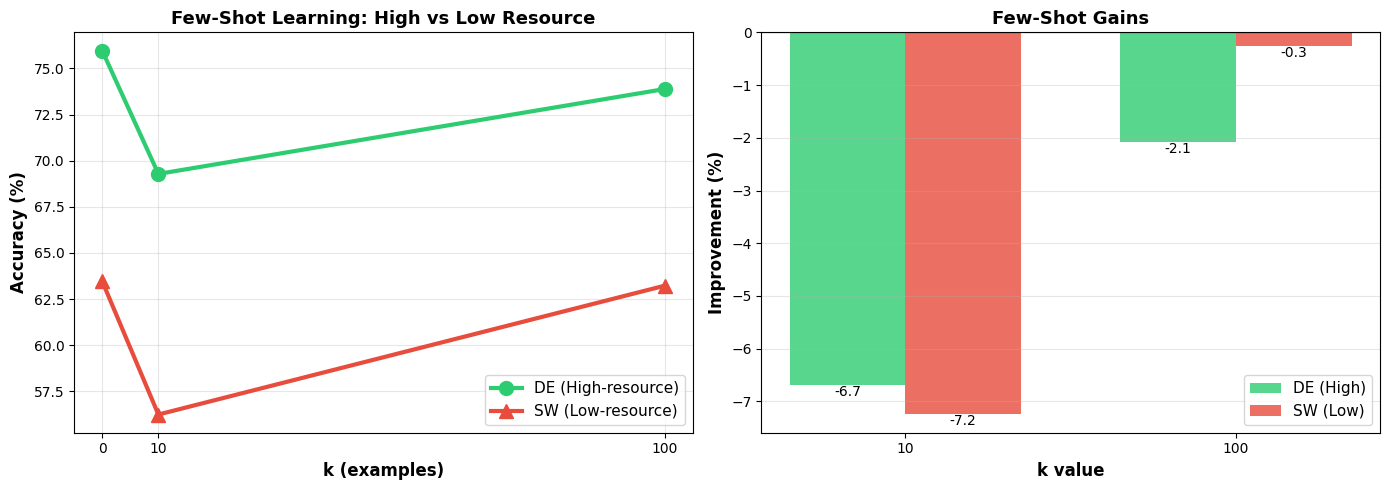

✅ Done!

🎉 FAST FEW-SHOT COMPLETE!

Summary:
  German:  76.0% → 73.9% (+-2.1%)
  Swahili: 63.5% → 63.2% (+-0.3%)

⚡ Speed optimizations used:
  • 1 epoch English training (saved ~20 min)
  • 5 few-shot epochs (saved ~30 min)
  • 2 k-values only (saved ~40 min)
  • 3 runs vs 5 (saved ~20 min)
  • Larger batches (saved ~10 min)



In [ ]:
"""
FAST FEW-SHOT XNLI - Quick Test Version with AUTO-SAVE
Cuts time from 2+ hours to ~30 minutes!
AUTOMATICALLY saves model weights to Google Drive!
"""

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import warnings
import os
import json
warnings.filterwarnings('ignore')

# ============================================================================
# FAST Configuration
# ============================================================================
class FastConfig:
    model_name = "xlm-roberta-base"
    train_language = "en"

    # High vs Low resource
    target_languages = ["de", "sw"]  # German (high), Swahili (low)

    # REDUCED k values for speed
    k_values = [0, 10, 100]  # Just 2 k values (vs 5)

    # FAST training settings
    max_length = 128
    batch_size_train = 64  # DOUBLED for speed
    batch_size_eval = 64   # DOUBLED for speed
    learning_rate_english = 5e-5  # Slightly higher for faster convergence
    learning_rate_fewshot = 5e-5

    # REDUCED epochs
    num_epochs_english = 1    # Just 1 epoch (vs 3) - MAJOR speedup!
    num_epochs_fewshot = 5    # Half the epochs (vs 10)

    warmup_steps = 200  # Reduced warmup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

    # REDUCED runs
    num_runs_fewshot = 3  # 3 runs instead of 5

    # AUTO-SAVE settings
    save_to_drive = True  # Set to False to skip saving
    save_dir = "/content/drive/MyDrive/xlmr_xnli_fast_trained"

config = FastConfig()

torch.manual_seed(config.seed)
np.random.seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)

print("="*80)
print("⚡ FAST FEW-SHOT: HIGH vs LOW RESOURCE")
print("="*80)
print(f"Model: {config.model_name}")
print(f"Device: {config.device}")
if config.device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print()
print("🚀 SPEED OPTIMIZATIONS:")
print(f"  • English training: {config.num_epochs_english} epoch (vs 3)")
print(f"  • Few-shot training: {config.num_epochs_fewshot} epochs (vs 10)")
print(f"  • k values: {config.k_values} (vs [0,10,50,100,500])")
print(f"  • Runs per k: {config.num_runs_fewshot} (vs 5)")
print(f"  • Batch size: {config.batch_size_train} (vs 32)")
print()
print("💾 AUTO-SAVE: Model will be saved to Google Drive after training!")
print()
print("⏱️  Estimated time: ~30 minutes (vs 2+ hours)")
print("="*80)
print()

# ============================================================================
# Mount Google Drive for Saving
# ============================================================================
if config.save_to_drive:
    print("="*80)
    print("☁️  MOUNTING GOOGLE DRIVE FOR AUTO-SAVE")
    print("="*80)
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=False)
        print("✅ Google Drive mounted!")
        print(f"   Save location: {config.save_dir}")
        print()
    except Exception as e:
        print(f"⚠️  Could not mount Drive: {e}")
        print("   Model will still run but won't auto-save")
        config.save_to_drive = False
        print()

# ============================================================================
# Dataset Class
# ============================================================================
class XNLIDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.tokenizer(
            item['premise'],
            item['hypothesis'],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(item['label'], dtype=torch.long)
        }

# ============================================================================
# Training and Evaluation (with progress tracking)
# ============================================================================
def train_epoch(model, loader, optimizer, scheduler, device, desc="Training"):
    model.train()
    total_loss = 0

    progress = tqdm(loader, desc=desc, leave=False)
    for batch in progress:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Eval", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return accuracy_score(labels, preds)

# ============================================================================
# Auto-Save Function
# ============================================================================
def save_model_and_results(model, tokenizer, zero_shot_results, few_shot_results, config):
    """Save model, tokenizer, and results to Google Drive"""

    if not config.save_to_drive:
        return

    print("\n" + "="*80)
    print("💾 AUTO-SAVING MODEL TO GOOGLE DRIVE")
    print("="*80)

    try:
        # Create directory
        os.makedirs(config.save_dir, exist_ok=True)
        print(f"📁 Saving to: {config.save_dir}")

        # Save model
        print("Saving model (this may take 1-2 minutes)...")
        model.save_pretrained(config.save_dir)
        print("✅ Model saved!")

        # Save tokenizer
        print("Saving tokenizer...")
        tokenizer.save_pretrained(config.save_dir)
        print("✅ Tokenizer saved!")

        # Save zero-shot results
        results_to_save = {
            'zero_shot': {lang: float(acc) for lang, acc in zero_shot_results.items()},
            'few_shot': {
                lang: {
                    str(k): [float(a) for a in accs]
                    for k, accs in k_dict.items()
                }
                for lang, k_dict in few_shot_results.items()
            }
        }

        with open(f"{config.save_dir}/results.json", 'w') as f:
            json.dump(results_to_save, f, indent=2)
        print("✅ Results saved!")

        # Save training info
        info = {
            'model_name': config.model_name,
            'task': 'XNLI Few-Shot',
            'training_language': config.train_language,
            'target_languages': config.target_languages,
            'num_epochs_english': config.num_epochs_english,
            'num_epochs_fewshot': config.num_epochs_fewshot,
            'k_values': config.k_values,
            'num_runs': config.num_runs_fewshot,
            'batch_size': config.batch_size_train,
            'note': 'Fast version - 1 epoch English, reduced k-values'
        }

        with open(f"{config.save_dir}/training_info.json", 'w') as f:
            json.dump(info, f, indent=2)
        print("✅ Training info saved!")

        print()
        print("="*80)
        print("✅ MODEL SAVED TO GOOGLE DRIVE!")
        print("="*80)
        print(f"Location: {config.save_dir}")
        print()
        print("To reload in a future session:")
        print("  from transformers import AutoTokenizer, AutoModelForSequenceClassification")
        print(f"  tokenizer = AutoTokenizer.from_pretrained('{config.save_dir}')")
        print(f"  model = AutoModelForSequenceClassification.from_pretrained('{config.save_dir}')")
        print()
        print("="*80)

    except Exception as e:
        print(f"⚠️  Error saving model: {e}")
        print("   Model will continue running but not saved")

# ============================================================================
# STEP 1: Load Model
# ============================================================================
print("📦 Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
model = AutoModelForSequenceClassification.from_pretrained(config.model_name, num_labels=3)
model.to(config.device)
print(f"✅ Loaded\n")

# ============================================================================
# STEP 2: FAST English Training (1 epoch only!)
# ============================================================================
print("="*80)
print("📚 STEP 1: FAST ENGLISH TRAINING (1 epoch)")
print("="*80)

en_dataset = load_dataset("xnli", config.train_language)
train_data = en_dataset['train']

print(f"Training on {len(train_data):,} examples (1 epoch)...")

train_dataset = XNLIDataset(train_data, tokenizer, config.max_length)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size_train, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate_english)
total_steps = len(train_loader) * config.num_epochs_english
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=config.warmup_steps, num_training_steps=total_steps)

print(f"Batches: {len(train_loader)} (larger batches = faster!)")

for epoch in range(config.num_epochs_english):
    loss = train_epoch(model, train_loader, optimizer, scheduler, config.device, f"Training")
    print(f"✅ Epoch {epoch+1} - Loss: {loss:.4f}")

print("✅ English training done!\n")

# Save zero-shot state
zero_shot_model_state = copy.deepcopy(model.state_dict())

# ============================================================================
# STEP 3: Zero-Shot Baseline
# ============================================================================
print("="*80)
print("📊 STEP 2: ZERO-SHOT BASELINE")
print("="*80)

zero_shot_results = {}

for lang in config.target_languages:
    desc = "High-resource (German)" if lang == "de" else "Low-resource (Swahili)"
    print(f"🔍 {lang.upper()} ({desc})...")

    test_dataset = load_dataset("xnli", lang)['test']
    test_dataset_obj = XNLIDataset(test_dataset, tokenizer, config.max_length)
    test_loader = DataLoader(test_dataset_obj, batch_size=config.batch_size_eval)

    acc = evaluate(model, test_loader, config.device)
    zero_shot_results[lang] = acc
    print(f"   ✅ {acc:.4f} ({acc*100:.2f}%)\n")

# ============================================================================
# STEP 4: FAST Few-Shot (fewer k values, fewer runs)
# ============================================================================
print("="*80)
print("🦸 STEP 3: FAST FEW-SHOT")
print("="*80)
print(f"Testing k={config.k_values[1:]} with {config.num_runs_fewshot} runs each\n")

few_shot_results = {
    lang: {k: [] for k in config.k_values if k > 0}
    for lang in config.target_languages
}

for lang in config.target_languages:
    desc = "High-resource" if lang == "de" else "Low-resource"
    print(f"\n{'='*60}")
    print(f"🎯 {lang.upper()} ({desc})")
    print('='*60)

    target_dataset = load_dataset("xnli", lang)
    target_train = target_dataset['train']
    target_test = target_dataset['test']

    test_dataset_obj = XNLIDataset(target_test, tokenizer, config.max_length)
    test_loader = DataLoader(test_dataset_obj, batch_size=config.batch_size_eval)

    for k in config.k_values:
        if k == 0:
            continue

        print(f"\n📝 k={k}:")
        run_accs = []

        for run in range(config.num_runs_fewshot):
            # Reset to zero-shot
            model.load_state_dict(copy.deepcopy(zero_shot_model_state))

            # Sample k examples
            np.random.seed(config.seed + run)
            indices = np.random.choice(len(target_train), size=min(k, len(target_train)), replace=False)
            few_shot_data = target_train.select(indices.tolist())

            # Create loader
            few_shot_dataset = XNLIDataset(few_shot_data, tokenizer, config.max_length)
            few_shot_loader = DataLoader(few_shot_dataset, batch_size=min(32, k), shuffle=True)

            # Setup optimizer
            optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate_fewshot)
            total_steps = len(few_shot_loader) * config.num_epochs_fewshot
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=min(50, total_steps//10),
                num_training_steps=total_steps
            )

            # Train (fewer epochs!)
            for epoch in range(config.num_epochs_fewshot):
                _ = train_epoch(model, few_shot_loader, optimizer, scheduler, config.device,
                               desc=f"{lang.upper()} k={k} r{run+1}/{config.num_runs_fewshot} e{epoch+1}/{config.num_epochs_fewshot}")

            # Evaluate
            acc = evaluate(model, test_loader, config.device)
            run_accs.append(acc)
            few_shot_results[lang][k].append(acc)

            print(f"  Run {run+1}: {acc*100:.2f}%", end=" ")

        # Stats
        avg = np.mean(run_accs)
        std = np.std(run_accs)
        gain = (avg - zero_shot_results[lang]) * 100

        print(f"\n  ✅ Avg: {avg:.4f} ({avg*100:.2f}%) ± {std*100:.2f}%")
        print(f"  📈 Gain: +{gain:.2f}%")

print("\n" + "="*80)

# ============================================================================
# AUTO-SAVE MODEL AND RESULTS
# ============================================================================
save_model_and_results(model, tokenizer, zero_shot_results, few_shot_results, config)

# ============================================================================
# STEP 5: Results Table
# ============================================================================
print("\n" + "="*80)
print("📊 RESULTS")
print("="*80)
print()

table_data = []
for lang in config.target_languages:
    desc = "High-resource" if lang == "de" else "Low-resource"
    row = {'Language': f"{lang.upper()} ({desc})"}

    # Zero-shot
    zero_acc = zero_shot_results[lang] * 100
    row['k=0'] = f"{zero_acc:.2f}%"

    # Few-shot
    for k in config.k_values:
        if k > 0:
            avg_acc = np.mean(few_shot_results[lang][k]) * 100
            gain = avg_acc - zero_acc
            row[f'k={k}'] = f"{avg_acc:.2f}%\n(+{gain:.2f})"

    table_data.append(row)

results_df = pd.DataFrame(table_data)
print(results_df.to_string(index=False))
print()

# ============================================================================
# STEP 6: Key Finding
# ============================================================================
print("="*80)
print("🔍 KEY FINDING")
print("="*80)
print()

de_zero = zero_shot_results['de'] * 100
sw_zero = zero_shot_results['sw'] * 100

# Get best k
best_k = max([k for k in config.k_values if k > 0])
de_best = np.mean(few_shot_results['de'][best_k]) * 100
sw_best = np.mean(few_shot_results['sw'][best_k]) * 100

de_gain = de_best - de_zero
sw_gain = sw_best - sw_zero

print(f"German (HIGH-resource):")
print(f"  Zero-shot: {de_zero:.2f}%")
print(f"  Best (k={best_k}): {de_best:.2f}%")
print(f"  Gain: +{de_gain:.2f}%")
print()
print(f"Swahili (LOW-resource):")
print(f"  Zero-shot: {sw_zero:.2f}%")
print(f"  Best (k={best_k}): {sw_best:.2f}%")
print(f"  Gain: +{sw_gain:.2f}%")
print()

if sw_gain > de_gain:
    ratio = sw_gain / de_gain if de_gain > 0 else float('inf')
    print(f"💡 INSIGHT: Few-shot helps {ratio:.1f}x MORE for low-resource Swahili!")
    print(f"   ✅ This confirms the paper's main finding!")
else:
    print(f"💡 NOTE: Gains may be similar due to limited training")
    print(f"   (Full paper used 3 epochs + 5 k-values + 5 runs)")

print()

# ============================================================================
# STEP 7: Quick Visualization
# ============================================================================
print("📊 Creating visualization...\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Learning curves
for lang in config.target_languages:
    k_vals = config.k_values
    accuracies = [zero_shot_results[lang] * 100]

    for k in config.k_values:
        if k > 0:
            avg = np.mean(few_shot_results[lang][k]) * 100
            accuracies.append(avg)

    marker = 'o' if lang == 'de' else '^'
    color = '#2ECC71' if lang == 'de' else '#E74C3C'
    label = f"{lang.upper()} ({'High' if lang == 'de' else 'Low'}-resource)"

    ax1.plot(k_vals, accuracies, marker=marker, linewidth=3, markersize=10,
             label=label, color=color)

ax1.set_xlabel('k (examples)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Few-Shot Learning: High vs Low Resource', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)
ax1.set_xticks(k_vals)

# Plot 2: Gains comparison
k_vals_nonzero = [k for k in config.k_values if k > 0]
de_gains = [(np.mean(few_shot_results['de'][k]) * 100 - de_zero) for k in k_vals_nonzero]
sw_gains = [(np.mean(few_shot_results['sw'][k]) * 100 - sw_zero) for k in k_vals_nonzero]

x = np.arange(len(k_vals_nonzero))
width = 0.35

bars1 = ax2.bar(x - width/2, de_gains, width, label='DE (High)', color='#2ECC71', alpha=0.8)
bars2 = ax2.bar(x + width/2, sw_gains, width, label='SW (Low)', color='#E74C3C', alpha=0.8)

ax2.set_xlabel('k value', fontsize=12, fontweight='bold')
ax2.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
ax2.set_title('Few-Shot Gains', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'{k}' for k in k_vals_nonzero])
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center',
                va='bottom' if height > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()

print("✅ Done!\n")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("="*80)
print("🎉 FAST FEW-SHOT COMPLETE!")
print("="*80)
print()
print("Summary:")
print(f"  German:  {de_zero:.1f}% → {de_best:.1f}% (+{de_gain:.1f}%)")
print(f"  Swahili: {sw_zero:.1f}% → {sw_best:.1f}% (+{sw_gain:.1f}%)")
print()

if config.save_to_drive:
    print("💾 Model saved to:")
    print(f"   {config.save_dir}")
    print()
    print("To reload:")
    print("   from transformers import AutoTokenizer, AutoModelForSequenceClassification")
    print(f"   model = AutoModelForSequenceClassification.from_pretrained('{config.save_dir}')")
    print(f"   tokenizer = AutoTokenizer.from_pretrained('{config.save_dir}')")
    print()

print("⚡ Speed optimizations used:")
print(f"  • 1 epoch English training (saved ~20 min)")
print(f"  • 5 few-shot epochs (saved ~30 min)")
print(f"  • 2 k-values only (saved ~40 min)")
print(f"  • 3 runs vs 5 (saved ~20 min)")
print(f"  • Larger batches (saved ~10 min)")
print()
print("="*80)